In [1]:
from typing import List
from collections import Counter
from pprint import pprint

In [2]:
def majority_vote(labels: List[str]) -> str:
    '''Assumes that labels are ordered from nearest to farthest'''
    vote_counts = Counter(labels)
    winner, winners_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                      for count in vote_counts.values()
                      if count == winners_count])
    if num_winners == 1:
        return winner #unique winner, so return it
    else:
        return majority_vote(labels[:-1]) #tyr again without the farthest

In [3]:
labels = ['a','a', 'b', 'b', 'c', 'd']
majority_vote(labels)

'a'

# KNN classify

In [59]:
from typing import NamedTuple
from linearalgebra import Vector, distance

In [60]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str
def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
    #order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))
    #find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    return majority_vote(k_nearest_labels)

# The Iris Dataset

In [42]:
import requests

In [43]:
data = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

In [215]:
with open('iris.data', 'w') as file:
    file.write(data.text)

In [61]:
from typing import Dict
import csv
from collections import defaultdict

In [62]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    '''sepal_length, sepal_width, petal_length, petal_width, class'''
    measurements = [float(value) for value in row[:-1]]
    #class is eg 'iris-virginica'; we just want 'virginica'
    label = row[-1].split('-')[-1]
#     print(measurements, label)|
    return LabeledPoint(measurements, label)

In [63]:
with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

In [64]:
points_by_species: Dict[str, List[Vector]] = defaultdict(list)

In [65]:
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

In [66]:
from matplotlib import pyplot as plt

In [67]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']

In [68]:
pairs = [(i, j) for i in range(4) for j in range(4) if i>j]
marks = ['+', '.', 'x']

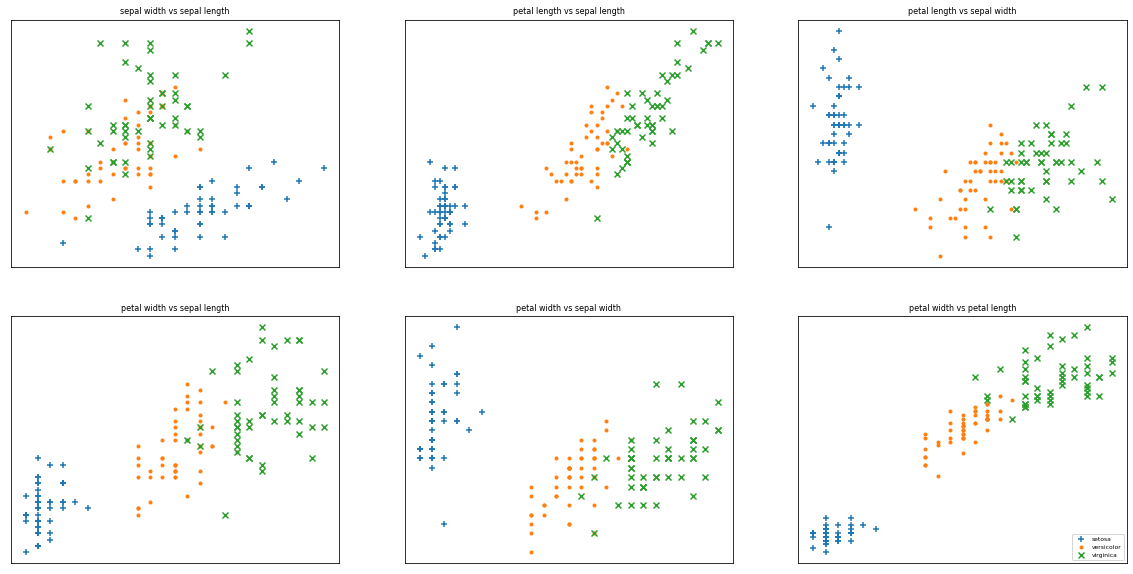

In [69]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
            
ax[-1][-1].legend(loc='lower right', prop={'size':6})
plt.show()

# Finally

In [70]:
import random
from machineLearning import split_data
from linearalgebra import distanceAlt

In [71]:
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

In [72]:
assert len(iris_train) == 0.7*150
assert len(iris_test) == 0.3*150

In [73]:
from typing import Tuple

In [74]:
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

In [75]:
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        confusion_matrix[(predicted, actual)] += 1
        
pct_correct = num_correct/len(iris_test)

In [225]:
print('Confusion matrix')
pprint(confusion_matrix)
print('Percentage correct', pct_correct)

Confusion matrix
defaultdict(<class 'int'>,
            {('setosa', 'setosa'): 13,
             ('versicolor', 'versicolor'): 15,
             ('virginica', 'virginica'): 16})
Percentage correct 0.9777777777777777


# The Curse of Dimensionality

In [28]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

random_point(3)

[0.6394110628821505, 0.22951422470938387, 0.5272370763287079]

In [29]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [30]:
print(random_distances(1, 3))
print(random_distances(2, 3))

[0.1496158530115279, 0.6839993354700503, 0.7321707702429464]
[0.07192170940789318, 0.5178307582268927, 0.5928631058586027]


In [31]:
import tqdm

In [32]:
dimensions = range(1, 101)
avg_distances = []
min_distances = []

In [76]:
random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    randomDistanceValue = random_distances(dim, 10000)
    # 10,000 random pairs
    avg_distances.append(sum(randomDistanceValue)/10000)
    # track the average
    min_distances.append(min(randomDistanceValue))
    # tracks the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


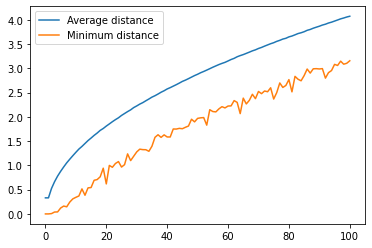

In [88]:
plt.plot(avg_distances, label='Average distance')
plt.plot(min_distances, label='Minimum distance')
plt.legend()
plt.show()

In [80]:
min_avg_ratio = [min_dist / avg_dict for min_dist, avg_dict in zip(min_distances, avg_distances)]

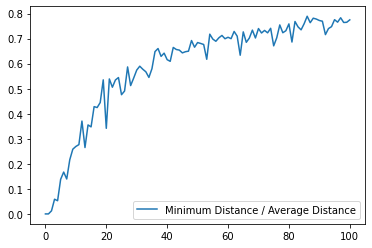

In [89]:
plt.plot(min_avg_ratio, label='Minimum Distance / Average Distance')
plt.legend()
plt.show()